# Toy inverse modeling with SWAMPE-JAX: infer radiative + drag timescales from a final snapshot

This notebook is a minimal, fully-differentiable inverse problem built around the JAX shallow-water model in `my_swamp`.

What it demonstrates:
1) A differentiable forward model (spectral SW on the sphere) that can be used inside gradient-based inference.
2) A “toy” parameter inference problem for the **radiative timescale** `taurad` and **drag timescale** `taudrag`.
3) **Final-time-only fitting**: we generate “truth” by running exactly **10 model timesteps**, and the likelihood compares **only the final temperature map** (no intermediate-time loss).

High-level workflow:
- Precompute the static spectral machinery once (basis, quadrature, diffusion, etc.).
- Define a forward operator that returns only `T(t_final)`.
- Generate synthetic observations `T_obs = T_true + noise`.
- Explore the 2D loss landscape.
- Run plain HMC (not NUTS) to infer `(taurad, taudrag)`.

In [1]:
# --- Imports and environment checks (try Mac GPU via Metal / "MPSGraph") ---

import os
import sys
import time
from contextlib import contextmanager
from dataclasses import replace
from pathlib import Path
import importlib.util

# If you already imported JAX in this kernel, backend selection won't change.
if "jax" in sys.modules:
    print("⚠️ JAX is already imported in this kernel. Restart the kernel to switch to Metal/GPU.")

# Prefer Metal if the plugin is installed; otherwise don't force anything.
# Note: JAX uses platform name "metal" (not torch's "mps").
have_jax_metal = importlib.util.find_spec("jax_metal") is not None
if have_jax_metal:
    # JAX_PLATFORMS controls which backends are initialized; first is default. (docs)
    # Putting cpu second gives a fallback target for manual device placement if needed.
    os.environ.setdefault("JAX_PLATFORMS", "metal,cpu")

    # Apple recommends this when using jaxlib newer than the minimum listed for your jax-metal.
    os.environ.setdefault("ENABLE_PJRT_COMPATIBILITY", "1")

# Optional: avoid XLA grabbing a large chunk of unified memory up front.
os.environ.setdefault("XLA_PYTHON_CLIENT_PREALLOCATE", "false")

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Optional: posterior diagnostics
import arviz as az

# JAX + NumPyro
import jax
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_value

# IMPORTANT:
# Apple’s Metal plugin currently lists float64 + complex as unsupported.
# For "try GPU" mode, do NOT enable x64 here.
# If you want the original numerics back, set this True (but expect Metal to fail / fall back).
jax.config.update("jax_enable_x64", False)

print("JAX version:", jax.__version__)
print("NumPyro version:", numpyro.__version__)
print("ArviZ version:", az.__version__)
print("JAX default backend:", jax.default_backend())
print("JAX devices:", jax.devices())

# Sanity check: ensure at least one op executes and report device placement.
try:
    x = jnp.ones((1024, 1024), dtype=jnp.float32)
    y = (x @ x).block_until_ready()
    print("Sanity matmul device:", y.device())
except Exception as e:
    print("⚠️ Sanity matmul failed:", repr(e))
    print("If this is a Metal dtype/unsupported-op error, you may need to run CPU-only for this notebook.")

# ---- Matplotlib style ----
STYLE_FILE = "science.mplstyle"
if Path(STYLE_FILE).exists():
    plt.style.use(STYLE_FILE)
else:
    print(f"⚠️ Style file not found: {STYLE_FILE!r}. Using matplotlib defaults.")

# ---- Ensure we can import the local codebase ----
REPO_ROOT = Path(".").resolve()
if (REPO_ROOT / "my_swamp").exists():
    sys.path.insert(0, str(REPO_ROOT))

from my_swamp.model import build_static, RunFlags
import my_swamp.model as swamp_model  # internal helpers (_init_state_from_fields, _step_once)

# Reproducibility
np.random.seed(0)

@contextmanager
def walltime(desc: str):
    """Print wall-clock runtime for a single long call (does not interfere with tqdm bars)."""
    t0 = time.perf_counter()
    print(f"{desc} ...")
    try:
        yield
    finally:
        dt = time.perf_counter() - t0
        print(f"{desc} took {dt:.2f} s")


JAX version: 0.6.2
NumPyro version: 0.19.0
ArviZ version: 0.23.4
JAX default backend: cpu
JAX devices: [CpuDevice(id=0)]
⚠️ Sanity matmul failed: TypeError("'Device' object is not callable")
If this is a Metal dtype/unsupported-op error, you may need to run CPU-only for this notebook.


## 0) Precompute “static” spectral machinery once (critical for HMC/JIT)

`my_swamp` caches Gauss–Legendre quadrature and Legendre bases at the module level for performance.

To avoid accidentally caching JAX tracers (which can happen if basis builders are first called inside a `jax.jit` trace), this notebook builds the static spectral machinery **once, up front**.

For inference, we keep the large static arrays fixed and only treat a couple of **dynamic scalars** (`taurad`, `taudrag`) as unknowns.

In [2]:
# --- Notebook runtime knobs (FAST defaults) ---
# The defaults here are chosen to run quickly on a laptop CPU while still demonstrating inference.
FAST_MODE = True

# MCMC (NUTS) configuration
NUM_WARMUP = 50 if FAST_MODE else 500
NUM_SAMPLES = 100 if FAST_MODE else 1000
MAX_TREE_DEPTH = 4 if FAST_MODE else 9

# Loss-landscape grid resolution (smaller = faster)
LOSS_GRID_N = 21 if FAST_MODE else 35

# Posterior predictive draws (smaller = faster)
PP_SAMPLES = 50 if FAST_MODE else 200
PP_BATCH_SIZE = 10

# --- Forward-model configuration ---
M = 42                  # supported: 42, 63, 106 (in this codebase)
dt = 60.0             # seconds (M=42 default in SWAMPE tables)
starttime = 2           # scan starts at t=2 due to the 2-level scheme initialization

# Final-time-only experiment: exactly 10 timesteps for truth and for simulation.
n_steps = 500
tmax = starttime + n_steps
t_seq = jnp.arange(starttime, tmax, dtype=jnp.int32)

# Planet-ish parameters (these mostly set nondimensional scales)
a = 8.2e7               # m
omega = 3.2e-5          # rad/s
g = 9.8                 # m/s^2
Phibar = 3.0e5          # reference geopotential (m^2/s^2)

# Forcing amplitude (equilibrium day-night geopotential contrast)
DPhieq = 4.0e6          # m^2/s^2
K6 = 1.24e33            # hyperdiffusion coefficient

# Enable forcing for the timescale-inference toy problem.
# blowup_rms is set extremely high so the "dead simulation" early-exit never triggers inside MCMC.
flags = RunFlags(
    forcflag=True,
    diffflag=True,
    expflag=False,       # modified Euler branch (see my_swamp/modEuler_tdiff.py notes)
    modalflag=True,
    alpha=0.01,
    blowup_rms=1.0e30,
)

# Placeholder taus: we will *replace* these inside the forward operator.
TAU_PLACEHOLDER = 86400.0  # seconds

with walltime("Build static spectral machinery"):
    static_base = build_static(
        M=M,
        dt=dt,
        a=a,
        omega=omega,
        g=g,
        Phibar=Phibar,
        taurad=TAU_PLACEHOLDER,
        taudrag=TAU_PLACEHOLDER,
        DPhieq=DPhieq,
        K6=K6,
        K6Phi=None,
        test=None,
    )

print(f"Grid: I={static_base.I} longitudes, J={static_base.J} latitudes.")
print(f"Time integration: starttime={starttime}, n_steps={n_steps}, t_final={int(t_seq[-1])}.")


Build static spectral machinery ...
Build static spectral machinery took 0.55 s
Grid: I=128 longitudes, J=64 latitudes.
Time integration: starttime=2, n_steps=500, t_final=501.


In [3]:
def phi_to_temperature(Phi: jnp.ndarray, *, T_ref: float = 300.0, phi_to_T_scale: float = 4.0e4) -> jnp.ndarray:
    """Toy observation operator: geopotential perturbation -> temperature (K)."""
    return T_ref + Phi / phi_to_T_scale


def seconds_to_hours(x: float) -> float:
    return float(x) / 3600.0


# For plotting axes
lon_deg = np.asarray(static_base.lambdas) * 180.0 / np.pi
lat_deg = np.arcsin(np.asarray(static_base.mus)) * 180.0 / np.pi


def plot_map(field2d: np.ndarray, *, title: str, cbar_label: str = "", vmin=None, vmax=None) -> None:
    plt.figure(figsize=(9, 6))
    plt.pcolormesh(lon_deg, lat_deg, field2d, shading="auto", vmin=vmin, vmax=vmax)
    plt.xlabel("longitude (deg)")
    plt.ylabel("latitude (deg)")
    plt.title(title)
    cb = plt.colorbar()
    cb.set_label(cbar_label)
    plt.tight_layout()

## 2) Differentiable forward operator that returns only a final snapshot

Forward operator:

`θ = (taurad, taudrag)  →  T_final`

Key design constraints requested here:
- We run exactly **10 timesteps** for both truth and simulation.
- The inverse problem uses **only the final map** `T(t_final)`.
- The implementation avoids storing intermediate snapshots to keep HMC lightweight.

In [4]:
# Final-time-only forward operator: θ = (taurad, taudrag) -> T(t_final)

def simulate_final_state(
    *,
    static,
    flags,
    state0,
    t_seq: jnp.ndarray,
    test,
    Uic: jnp.ndarray,
    Vic: jnp.ndarray,
):
    """Run the model for all times in t_seq and return only the final State.

    This avoids storing the full time history, which is important when the forward
    model is called many times inside HMC.
    """
    n = int(t_seq.shape[0])

    def body_fun(i, carry):
        t = t_seq[i]
        new_carry, _ = swamp_model._step_once(carry, t, static, flags, test, Uic, Vic)
        return new_carry

    return jax.lax.fori_loop(0, n, body_fun, state0)


def _forward_final_phi(theta: jnp.ndarray) -> jnp.ndarray:
    """Return geopotential perturbation Φ at final time.

    Args:
        theta: shape (2,) = [taurad, taudrag] in seconds
    Returns:
        Phi_final: shape (J, I)
    """
    taurad, taudrag = theta[0], theta[1]

    # Replace only the dynamic scalars; keep all large spectral arrays fixed.
    static = replace(static_base, taurad=taurad, taudrag=taudrag)

    # Physically consistent "rest" initialization:
    #   U=V=0, delta=0, Phi=0, and eta = f = 2*omega*sin(lat).
    mu = static.mus[:, None]  # (J, 1)
    eta0 = (2.0 * static.omega) * mu
    eta0 = jnp.broadcast_to(eta0, (static.J, static.I)).astype(jnp.float64)

    delta0 = jnp.zeros((static.J, static.I), dtype=jnp.float64)
    Phi0 = jnp.zeros((static.J, static.I), dtype=jnp.float64)
    U0 = jnp.zeros((static.J, static.I), dtype=jnp.float64)
    V0 = jnp.zeros((static.J, static.I), dtype=jnp.float64)

    state0 = swamp_model._init_state_from_fields(
        static=static,
        flags=flags,
        test=None,
        eta0=eta0,
        delta0=delta0,
        Phi0=Phi0,
        U0=U0,
        V0=V0,
    )

    last_state = simulate_final_state(
        static=static,
        flags=flags,
        state0=state0,
        t_seq=t_seq,
        test=None,
        Uic=U0,
        Vic=V0,
    )
    return last_state.Phi_curr  # (J, I)


def _forward_final_temp(theta: jnp.ndarray) -> jnp.ndarray:
    Phi_final = _forward_final_phi(theta)
    return phi_to_temperature(Phi_final, T_ref=300.0, phi_to_T_scale=4.0e4)


# JIT wrappers (these will compile on first call)
forward_final_phi = jax.jit(_forward_final_phi)
forward_final_temp = jax.jit(_forward_final_temp)

## 3) Generate synthetic observations from a “truth” run

We pick a “true” parameter vector θ\* and generate synthetic observations:

`T_obs = T_final(θ*) + ε`, with i.i.d. Gaussian noise.

Because we only fit the final snapshot, the observation tensor is just a single `(J, I)` 2D field.

Truth taurad [hours]: 4.166666666666667
Truth taudrag [hours]: 0.5555555555555556
Compile + run truth forward model ...
Compile + run truth forward model took 0.68 s
T_obs shape: (64, 128)


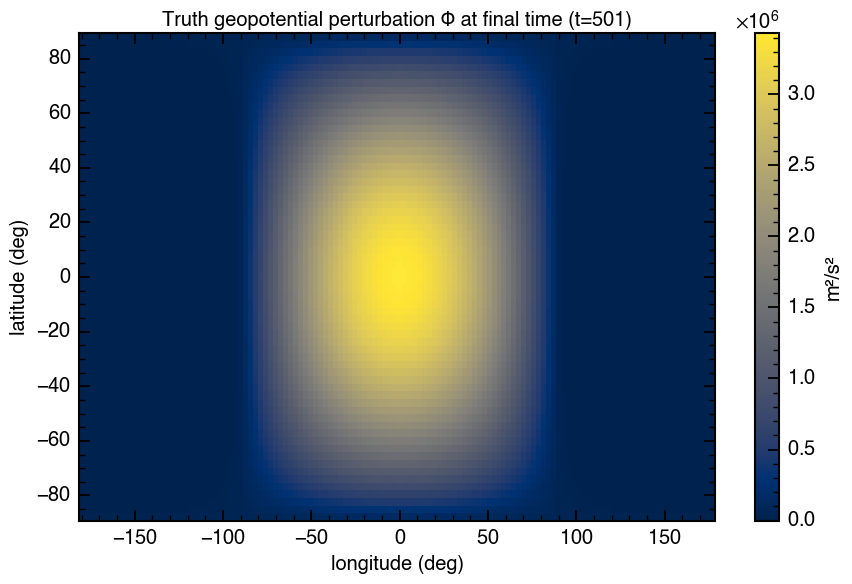

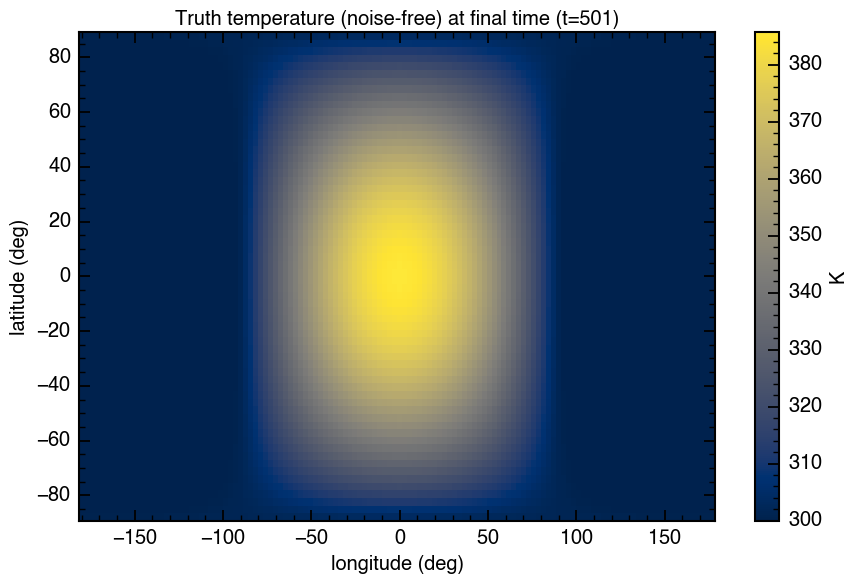

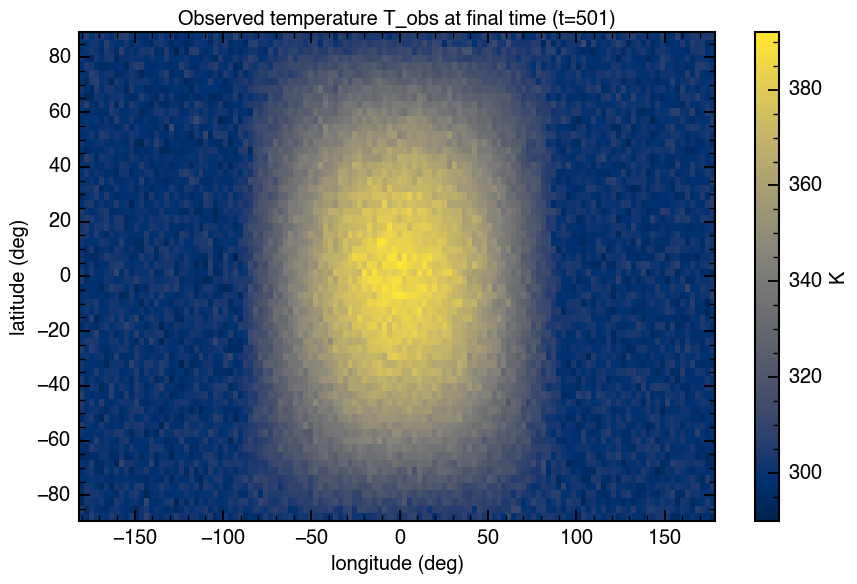

In [5]:
# --- Ground truth timescales (theta_true = [taurad, taudrag]) ---
taurad_true = 1.5e4 
taudrag_true = 2e3
theta_true = jnp.array([taurad_true, taudrag_true], dtype=jnp.float64)

print("Truth taurad [hours]:", seconds_to_hours(taurad_true))
print("Truth taudrag [hours]:", seconds_to_hours(taudrag_true))

# Simulate "truth" (final time only)
with walltime("Compile + run truth forward model"):
    Phi_true_final = forward_final_phi(theta_true)     # (J, I)
    T_true_final = forward_final_temp(theta_true)      # (J, I)

# Add observation noise (larger sigma -> easier geometry for MCMC in this toy demo)
sigma_obs = 3.0  # K
key = jr.PRNGKey(0)
T_obs = T_true_final + sigma_obs * jr.normal(key, shape=T_true_final.shape)

print("T_obs shape:", T_obs.shape)

# --- Plot truth vs observation ---
t_final = int(t_seq[-1])
plot_map(
    np.asarray(Phi_true_final),
    title=f"Truth geopotential perturbation Φ at final time (t={t_final})",
    cbar_label="m²/s²",
)
plot_map(
    np.asarray(T_true_final),
    title=f"Truth temperature (noise-free) at final time (t={t_final})",
    cbar_label="K",
)
plot_map(
    np.asarray(T_obs),
    title=f"Observed temperature T_obs at final time (t={t_final})",
    cbar_label="K",
)


## 4) Final-time-only loss function

Requested loss:
- Mean squared error (MSE) over the 2D final-time temperature map.
- No summation over intermediate observation times.

This is intentionally written as a small wrapper so you can later replace it with a different likelihood/cost without changing the inference plumbing.

In [6]:
def mse_final_temperature_loss(
    theta: jnp.ndarray,
    T_obs: jnp.ndarray,
    *,
    forward_fn=forward_final_temp,
) -> jnp.ndarray:
    """Final-time-only MSE over the 2D temperature map."""
    T_pred = forward_fn(theta)  # (J, I)
    return jnp.mean((T_pred - T_obs) ** 2)


loss_jit = jax.jit(mse_final_temperature_loss)
grad_loss = jax.jit(jax.grad(mse_final_temperature_loss))

# Quick smoke test: loss and gradient at a plausible initial guess
theta0 = jnp.array([2.0e4, 4.0e4], dtype=jnp.float64)

with walltime("Compile loss + grad (single call)"):
    L0 = loss_jit(theta0, T_obs)
    g0 = grad_loss(theta0, T_obs)

print("Initial guess theta0 = [taurad, taudrag] (s):", np.asarray(theta0))
print("Loss(theta0):", float(L0))
print("grad Loss(theta0):", np.asarray(g0))


Compile loss + grad (single call) ...
Compile loss + grad (single call) took 2.53 s
Initial guess theta0 = [taurad, taudrag] (s): [20000. 40000.]
Loss(theta0): 19.954025633328435
grad Loss(theta0): [3.76943882e-03 5.92066022e-06]


## 5) Visualize the loss landscape in timescale space

We infer exactly 2 parameters (`taurad`, `taudrag`), so we can compute the final-time MSE on a grid and plot contours.

Later we overlay accepted HMC states to confirm that sampling moves through the right region of parameter space.

Loss grid (rows=taurad):   0%|          | 0/21 [00:00<?, ?it/s]

Loss grid computed in 731.15 s


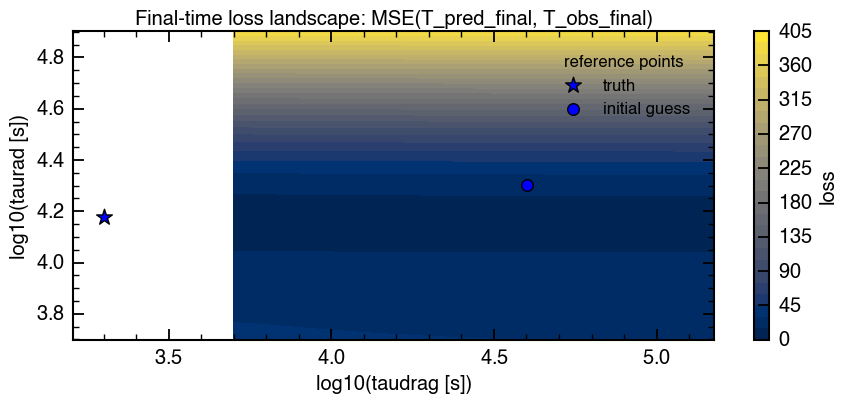

In [7]:
# Loss grid in (taurad, taudrag). Use log-spaced grids (seconds).
# Keep this small in FAST_MODE because it requires many forward-model calls.
taurad_grid = np.logspace(np.log10(5.0e3), np.log10(8.0e4), LOSS_GRID_N)
taudrag_grid = np.logspace(np.log10(5.0e3), np.log10(1.5e5), LOSS_GRID_N)

taudrag_grid_j = jnp.asarray(taudrag_grid, dtype=jnp.float64)

@jax.jit
def loss_row(taurad_scalar: jnp.ndarray) -> jnp.ndarray:
    """Vectorized loss over taudrag at fixed taurad."""
    return jax.vmap(
        lambda taudrag_scalar: mse_final_temperature_loss(
            jnp.array([taurad_scalar, taudrag_scalar], dtype=jnp.float64),
            T_obs,
        )
    )(taudrag_grid_j)

loss_grid = np.empty((len(taurad_grid), len(taudrag_grid)), dtype=np.float64)

t0 = time.perf_counter()
for i, taurad in enumerate(tqdm(taurad_grid, desc="Loss grid (rows=taurad)")):
    loss_grid[i, :] = np.asarray(loss_row(jnp.asarray(taurad, dtype=jnp.float64)))
dt_grid = time.perf_counter() - t0
print(f"Loss grid computed in {dt_grid:.2f} s")

# Plot contours in log-timescale coordinates (x=log10 taudrag, y=log10 taurad)
plt.figure(figsize=(9, 4.2))
cs = plt.contourf(np.log10(taudrag_grid), np.log10(taurad_grid), loss_grid, levels=30)
plt.xlabel("log10(taudrag [s])")
plt.ylabel("log10(taurad [s])")
plt.title("Final-time loss landscape: MSE(T_pred_final, T_obs_final)")
plt.colorbar(cs, label="loss")

plt.scatter([np.log10(taudrag_true)], [np.log10(taurad_true)], marker="*", s=140, label="truth")
plt.scatter([np.log10(float(theta0[1]))], [np.log10(float(theta0[0]))], marker="o", s=70, label="initial guess")
plt.legend(title="reference points")
plt.tight_layout()


## 6) Bayesian inverse problem + NUTS sampling (log-timescales, final snapshot only)


In [ ]:
# NumPyro model: priors + likelihood (final snapshot only)
#
# Key choices:
#   1) Sample log10 timescales (unconstrained geometry).
#   2) Use NUTS (adaptive path length).
#   3) Hard-reject NaN/Inf forward passes.

LOG10_TAURAD_PRIOR_MEAN = float(np.log10(2.0e4))
LOG10_TAUDRAG_PRIOR_MEAN = float(np.log10(4.0e4))
LOG10_PRIOR_STD = 0.7


def inverse_model(T_obs: jnp.ndarray, *, sigma_obs: float) -> None:
    log10_taurad = numpyro.sample(
        "log10_taurad",
        dist.Normal(LOG10_TAURAD_PRIOR_MEAN, LOG10_PRIOR_STD),
    )
    log10_taudrag = numpyro.sample(
        "log10_taudrag",
        dist.Normal(LOG10_TAUDRAG_PRIOR_MEAN, LOG10_PRIOR_STD),
    )

    taurad = 10.0 ** log10_taurad
    taudrag = 10.0 ** log10_taudrag

    theta = jnp.stack([taurad, taudrag]).astype(jnp.float64)
    T_pred = forward_final_temp(theta)

    finite = jnp.isfinite(T_pred).all()
    numpyro.factor("finite_forward", jnp.where(finite, 0.0, -jnp.inf))

    numpyro.sample(
        "T_obs",
        dist.Normal(T_pred, sigma_obs).to_event(2),
        obs=T_obs,
    )


# ---- NUTS configuration (fast + stable) ----
from numpyro.infer import NUTS, MCMC
from numpyro.infer.initialization import init_to_value

init_vals = {
    "log10_taurad": float(np.log10(taurad_true)),
    "log10_taudrag": float(np.log10(taudrag_true)),
}

kernel = NUTS(
    inverse_model,
    init_strategy=init_to_value(values=init_vals),  # ← FIX IS HERE
    target_accept_prob=0.8,
    max_tree_depth=6,
)

NUM_WARMUP = 100
NUM_SAMPLES = 200

key = jr.PRNGKey(1)

mcmc = MCMC(
    kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=1,
    progress_bar=True,
)

with walltime("Run NUTS"):
    mcmc.run(key, T_obs=T_obs, sigma_obs=float(sigma_obs))

mcmc.print_summary()

posterior = mcmc.get_samples()
print({k: v.shape for k, v in posterior.items()})

# Derived taus (seconds)
taurad_post = np.asarray(10.0 ** posterior["log10_taurad"])
taudrag_post = np.asarray(10.0 ** posterior["log10_taudrag"])

print(
    "taurad_post range (s):",
    float(taurad_post.min()),
    float(taurad_post.max()),
)
print(
    "taudrag_post range (s):",
    float(taudrag_post.min()),
    float(taudrag_post.max()),
)


Run NUTS ...


warmup:  18%|█▊        | 54/300 [1:06:50<2:29:10, 36.38s/it, 23 steps of size 6.35e-04. acc. prob=0.72]

## 7) Posterior diagnostics and parameter uncertainty

We use ArviZ to produce trace plots, posterior marginals, and pairwise structure for `(taurad, taudrag)`.

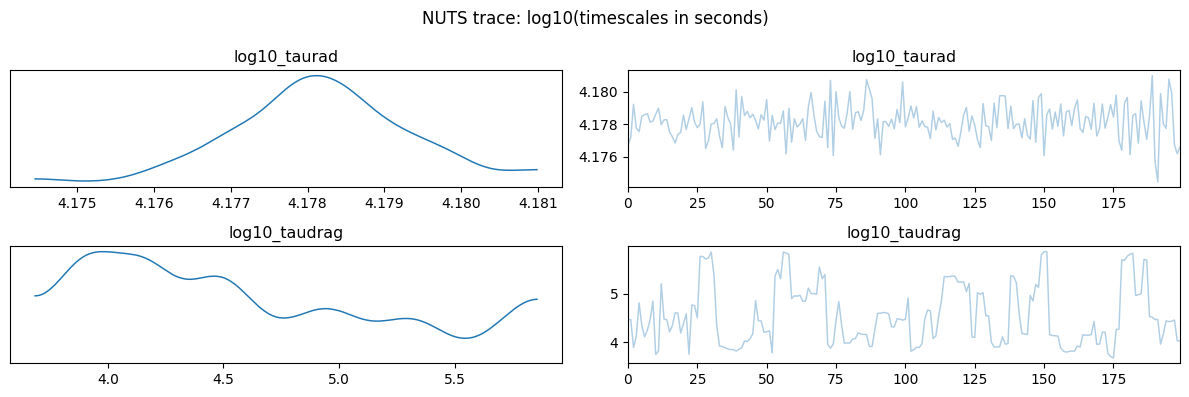

/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_17442/1681711981.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


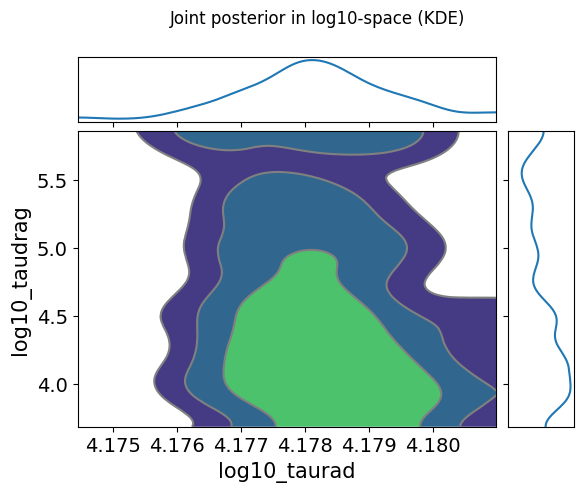

arviz - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_taurad,4.178,0.001,4.176,4.180,0.000,0.000,266.539,131.153,NaN
log10_taudrag,4.542,0.604,3.754,5.766,0.097,0.047,43.548,79.323,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
taurad,15072.278,36.860,15001.279,15135.728,2.300,3.804,266.539,131.153,NaN
taudrag,100859.758,172662.916,4817.920,574019.794,24532.793,27450.561,43.548,79.323,NaN


In [ ]:
from IPython.display import display

idata = az.from_numpyro(mcmc)

# Add derived seconds-valued variables for convenience.
# (ArviZ keeps posterior as an xarray Dataset.)
if "log10_taurad" in idata.posterior:
    idata.posterior = idata.posterior.assign(
        taurad=10.0 ** idata.posterior["log10_taurad"],
        taudrag=10.0 ** idata.posterior["log10_taudrag"],
    )

# Trace plots (log10 is typically easier to interpret for timescales)
axes = az.plot_trace(idata, var_names=["log10_taurad", "log10_taudrag"])
plt.suptitle("NUTS trace: log10(timescales in seconds)")
plt.tight_layout()
plt.show()

# Pair plot: KDE can fail if the chain is nearly degenerate; fall back to scatter.
try:
    ax = az.plot_pair(
        idata,
        var_names=["log10_taurad", "log10_taudrag"],
        kind="kde",
        marginals=True,
    )
    plt.suptitle("Joint posterior in log10-space (KDE)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Pair KDE failed (often due to near-degenerate samples). Falling back to scatter. Error:", repr(e))
    ax = az.plot_pair(
        idata,
        var_names=["log10_taurad", "log10_taudrag"],
        kind="scatter",
        marginals=True,
    )
    plt.suptitle("Joint posterior in log10-space (scatter fallback)")
    plt.tight_layout()
    plt.show()

summary_log10 = az.summary(idata, var_names=["log10_taurad", "log10_taudrag"], round_to=3)
display(summary_log10)

# Also show a seconds-valued summary (more intuitive units)
summary_sec = az.summary(idata, var_names=["taurad", "taudrag"], round_to=3)
display(summary_sec)


## 8) Posterior predictive uncertainty at the final time

We draw θ from the posterior, re-run the forward model, and compute:
- posterior mean temperature map at final time
- posterior standard deviation map at final time

This gives a spatial uncertainty diagnostic that is often more informative than parameter-only uncertainty.

Posterior predictive (batches):   0%|          | 0/5 [00:00<?, ?it/s]

Posterior predictive forward passes: S=50 in 0.78 s


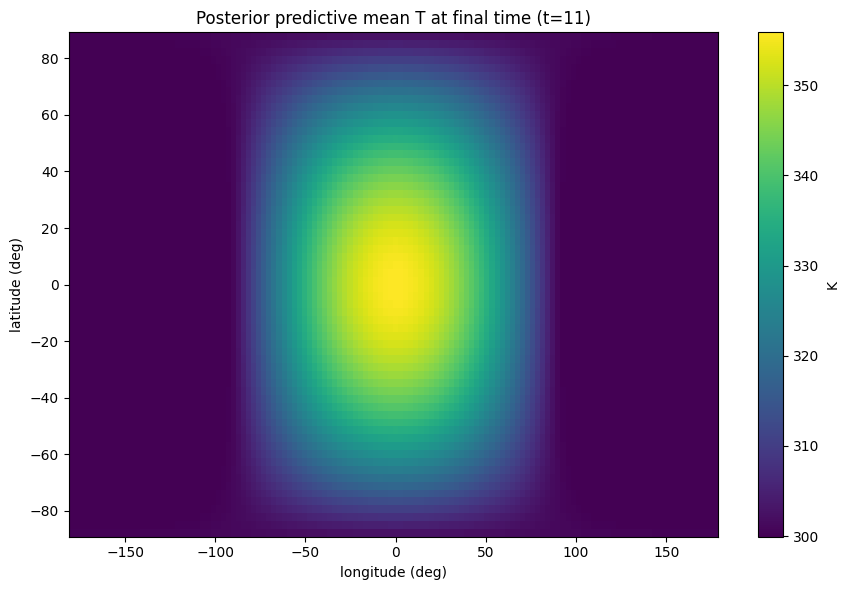

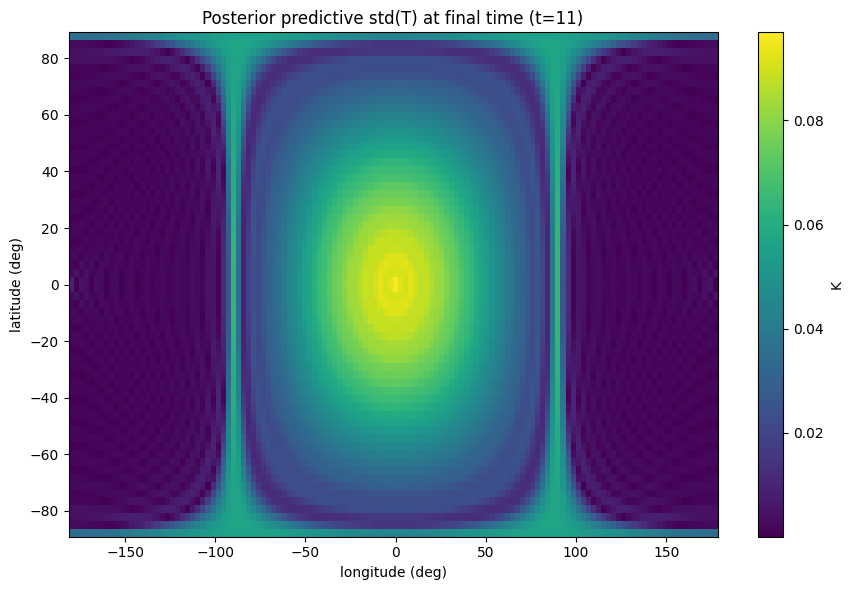

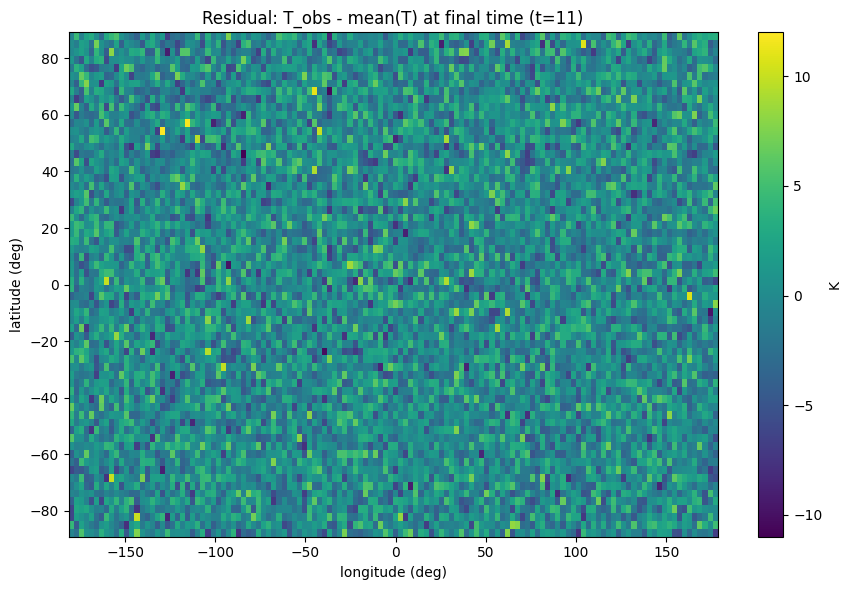

In [ ]:
# Posterior predictive at the final time (batching + tqdm for transparency)
posterior_size = int(posterior["log10_taurad"].shape[0])
S = min(PP_SAMPLES, posterior_size)

batch_size = int(PP_BATCH_SIZE)
S = (S // batch_size) * batch_size  # keep a whole number of batches to avoid extra JIT recompiles
if S == 0:
    raise RuntimeError("Not enough posterior samples for posterior predictive plotting.")

sub_idx = np.random.choice(posterior_size, size=S, replace=False)

theta_s = jnp.stack(
    [
        10.0 ** posterior["log10_taurad"][sub_idx],
        10.0 ** posterior["log10_taudrag"][sub_idx],
    ],
    axis=-1,
).astype(jnp.float64)  # (S, 2)

# Batched forward: (B,2)->(B,J,I)
forward_final_temp_batch = jax.jit(jax.vmap(_forward_final_temp, in_axes=(0,)))

T_pred_batches = []
t0 = time.perf_counter()
for i in tqdm(range(0, S, batch_size), desc="Posterior predictive (batches)"):
    theta_b = theta_s[i : i + batch_size]
    T_pred_batches.append(forward_final_temp_batch(theta_b))

T_pred_s = jnp.concatenate(T_pred_batches, axis=0)  # (S, J, I)
dt_pp = time.perf_counter() - t0
print(f"Posterior predictive forward passes: S={S} in {dt_pp:.2f} s")

T_mean = jnp.mean(T_pred_s, axis=0)
T_std = jnp.std(T_pred_s, axis=0)

t_final = int(t_seq[-1])
plot_map(np.asarray(T_mean), title=f"Posterior predictive mean T at final time (t={t_final})", cbar_label="K")
plot_map(np.asarray(T_std), title=f"Posterior predictive std(T) at final time (t={t_final})", cbar_label="K")
plot_map(np.asarray(T_obs - T_mean), title=f"Residual: T_obs - mean(T) at final time (t={t_final})", cbar_label="K")


## 9) MCMC traversal over the loss landscape


Extra fields: ['diverging']
Divergences (post-warmup): 0 / 200


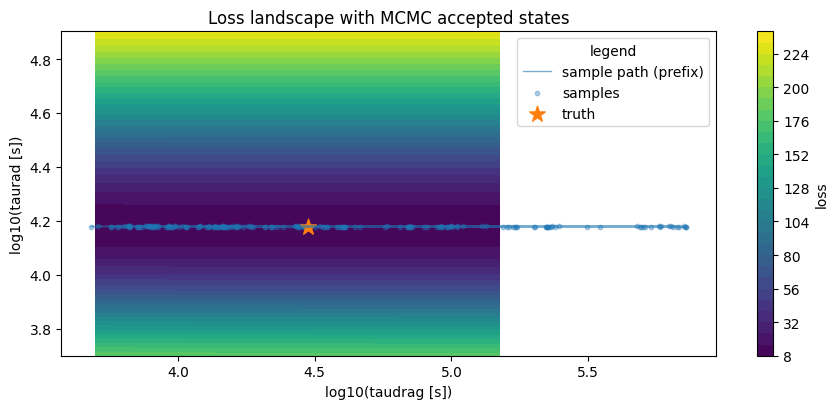

In [ ]:
# Extract chain in order (post-warmup)
taurad_s = np.asarray(10.0 ** posterior["log10_taurad"])
taudrag_s = np.asarray(10.0 ** posterior["log10_taudrag"])

# Optional diagnostics from NUTS/HMC (field names vary slightly by NumPyro version)
extra = mcmc.get_extra_fields()
print("Extra fields:", list(extra.keys()))

def maybe_plot_trace(key: str, *, ylabel: str, title: str) -> None:
    if key not in extra:
        return
    plt.figure(figsize=(9, 2.6))
    plt.plot(np.asarray(extra[key]))
    plt.xlabel("iteration (post-warmup)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

maybe_plot_trace("energy", ylabel="energy", title="Hamiltonian energy trace")
maybe_plot_trace("potential_energy", ylabel="potential energy", title="Potential energy trace")
maybe_plot_trace("accept_prob", ylabel="accept prob", title="Acceptance probability trace")
maybe_plot_trace("step_size", ylabel="step size", title="Step size trace")

if "diverging" in extra:
    n_div = int(np.asarray(extra["diverging"]).sum())
    print(f"Divergences (post-warmup): {n_div} / {len(taurad_s)}")

# Overlay posterior samples on the loss landscape (log-timescale coordinates)
plt.figure(figsize=(9, 4.2))
cs = plt.contourf(np.log10(taudrag_grid), np.log10(taurad_grid), loss_grid, levels=30)
plt.xlabel("log10(taudrag [s])")
plt.ylabel("log10(taurad [s])")
plt.title("Loss landscape with MCMC accepted states")
plt.colorbar(cs, label="loss")

# show a trajectory prefix (connect points)
prefix = min(250, len(taurad_s))
plt.plot(
    np.log10(taudrag_s[:prefix]),
    np.log10(taurad_s[:prefix]),
    "-",
    linewidth=1.0,
    alpha=0.6,
    label="sample path (prefix)",
)
plt.scatter(np.log10(taudrag_s), np.log10(taurad_s), s=10, alpha=0.35, label="samples")

plt.scatter([np.log10(taudrag_true)], [np.log10(taurad_true)], marker="*", s=140, label="truth")
plt.legend(title="legend")
plt.tight_layout()
plt.show()


## 10) “Recovered” timescales and comparison to truth

We summarize the posterior (median and credible intervals) and compare to θ\*.

For this synthetic-data toy problem, you should see posterior mass concentrate near the truth, assuming the priors are not overly restrictive and the run is stable.

Truth taurad (s): 15000.0   posterior 5/50/95%: [15014.04399177 15071.50423737 15132.42740955]
Truth taudrag (s): 30000.0   posterior 5/50/95%: [  6632.35345252  27584.7215856  576480.94864806]
Truth taurad (hours): 4.166666666666667
Truth taudrag (hours): 8.333333333333334
Posterior taurad (hours) 5/50/95%: [4.17056778 4.18652895 4.20345206]
Posterior taudrag (hours) 5/50/95%: [  1.8423204    7.66242266 160.13359685]


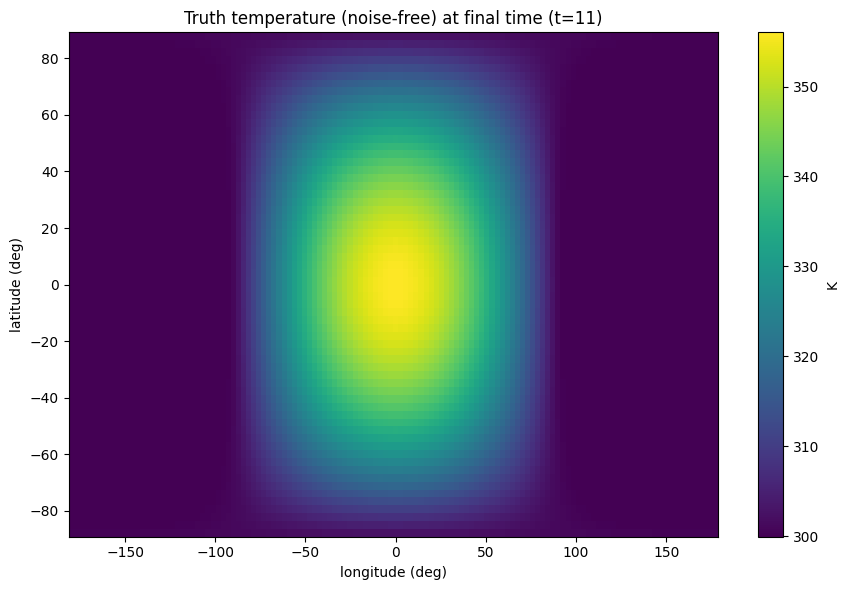

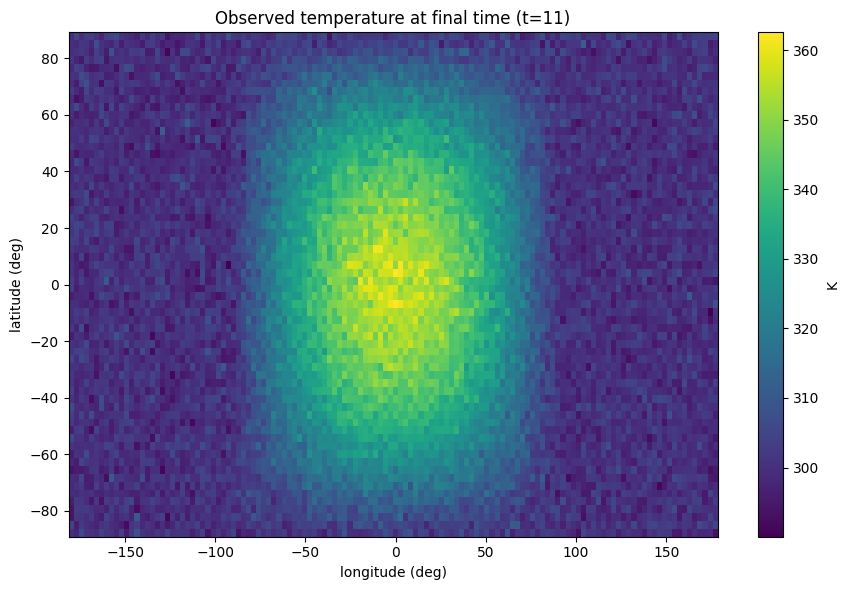

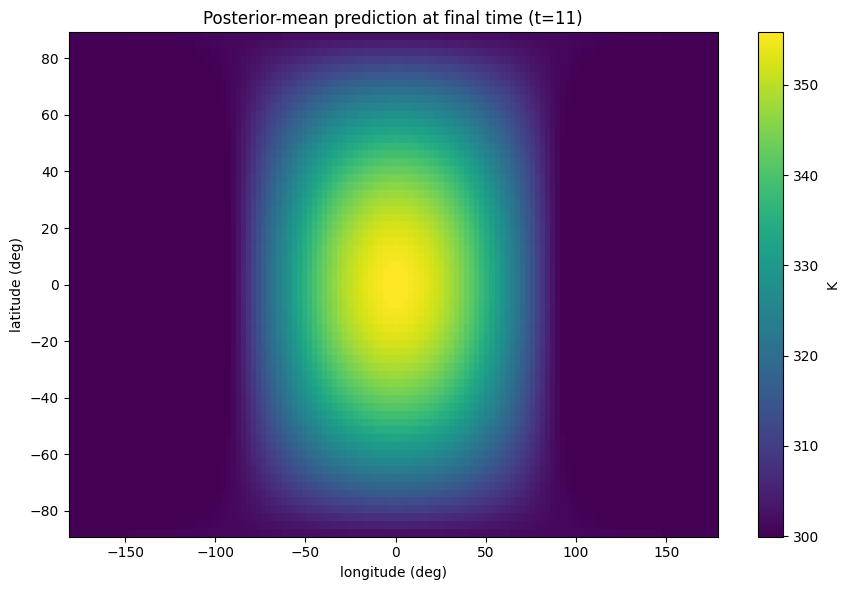

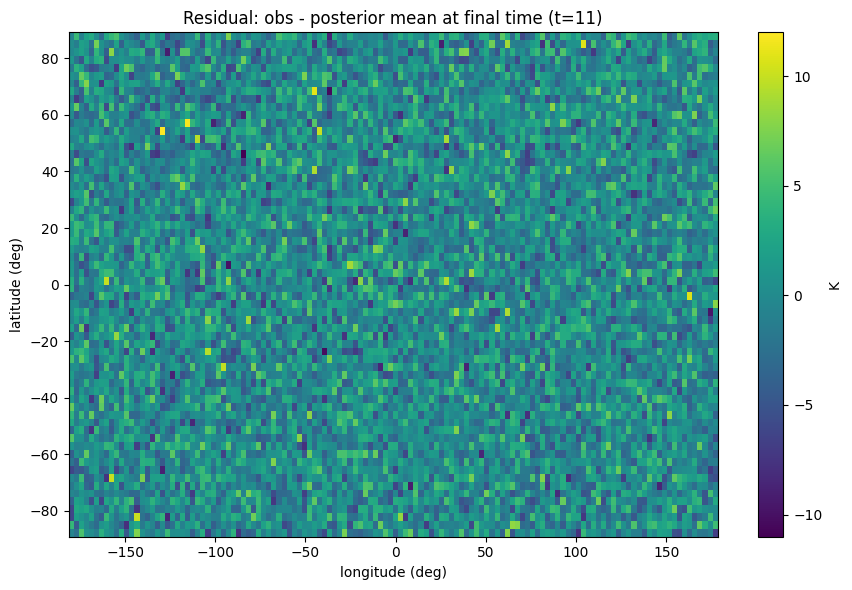

In [ ]:
taurad_post = np.asarray(10.0 ** posterior["log10_taurad"])
taudrag_post = np.asarray(10.0 ** posterior["log10_taudrag"])

def quantiles(x: np.ndarray) -> np.ndarray:
    return np.quantile(x, [0.05, 0.5, 0.95])

print("Truth taurad (s):", float(taurad_true), "  posterior 5/50/95%:", quantiles(taurad_post))
print("Truth taudrag (s):", float(taudrag_true), "  posterior 5/50/95%:", quantiles(taudrag_post))

print("Truth taurad (hours):", seconds_to_hours(taurad_true))
print("Truth taudrag (hours):", seconds_to_hours(taudrag_true))
print("Posterior taurad (hours) 5/50/95%:", quantiles(taurad_post) / 3600.0)
print("Posterior taudrag (hours) 5/50/95%:", quantiles(taudrag_post) / 3600.0)

theta_mean = jnp.array([jnp.mean(10.0 ** posterior["log10_taurad"]), jnp.mean(10.0 ** posterior["log10_taudrag"])], dtype=jnp.float64)
T_mean_pred = forward_final_temp(theta_mean)

t_final = int(t_seq[-1])
plot_map(np.asarray(T_true_final), title=f"Truth temperature (noise-free) at final time (t={t_final})", cbar_label="K")
plot_map(np.asarray(T_obs), title=f"Observed temperature at final time (t={t_final})", cbar_label="K")
plot_map(np.asarray(T_mean_pred), title=f"Posterior-mean prediction at final time (t={t_final})", cbar_label="K")
plot_map(np.asarray(T_obs - T_mean_pred), title=f"Residual: obs - posterior mean at final time (t={t_final})", cbar_label="K")


## Appendix: correctness notes and small recommended improvements

Notebook-level corrections made here:
1) Final-time-only fitting  
   The original notebook fit multiple observation times. This version fits **only the final snapshot**.

2) Rest-state absolute vorticity initialization  
   In SWAMPE’s formulation, `eta` is **absolute vorticity** (ζ + f). A physically consistent “at rest” initialization uses `eta = f = 2Ω sin(lat)` (and `delta=0`, `U=V=0`).  
   This notebook uses that consistent initialization for the forced/timescale problem.

3) Avoid storing intermediate time history  
   We run the integrator for 10 steps but only return the final state, which reduces memory pressure and aligns with final-time-only inference.

Source-code changes:
- None are strictly required for this notebook refactor. Everything is done from the notebook using the existing `my_swamp.model` internals.
- If you want this pattern permanently in the library, consider adding a public `simulate_final_state(...)` helper to `my_swamp/model.py` (thin wrapper around `_step_once` + `jax.lax.fori_loop`).

## Appendix: extending beyond the toy problem

Common extensions:
- Add more parameters: forcing amplitude `DPhieq`, diffusivity `K6`, planet parameters, etc.
- Use multiple observation types (winds, geopotential, masked regions), or heteroskedastic noise.
- Use multiple observation times again once you care about transient dynamics, but keep the “final-only” mode available for quick experiments.
- Replace the toy `phi_to_temperature` map with a more physical observation operator.